In [2]:
import pandas as pd
import numpy as np

# 时间戳生成（5分钟分辨率，从1月1号到6月30号）
time_index = pd.date_range(start="2024-01-01 00:00", end="2024-06-30 23:55", freq="5T")

# 数据生成函数
def generate_realistic_data(time_index):
    n = len(time_index)
    
    # 模拟电力需求：每日有两个高峰（早8点、晚6点），加日间随机波动
    power_demand = (
        0.5 + 0.3 * np.sin(2 * np.pi * (time_index.hour * 60 + time_index.minute) / (24 * 60))
        + 0.2 * np.random.normal(0, 0.1, n)
    )
    
    # 模拟热需求：冬季需求高（1月高，逐渐下降），昼夜波动（早晨高）
    heat_demand = (
        0.7 + 0.2 * (1 - np.sin(2 * np.pi * (time_index.month - 1) / 12))
        + 0.3 * np.sin(2 * np.pi * (time_index.hour - 6) / 24)
        + 0.2 * np.random.normal(0, 0.1, n)
    )
    
    # 模拟冷需求：夏季需求高（5-6月），正午需求高
    cooling_demand = (
        0.5 + 0.4 * np.clip(np.sin(2 * np.pi * (time_index.month - 5) / 6), 0, 1)
        + 0.3 * np.sin(2 * np.pi * (time_index.hour - 12) / 24)
        + 0.2 * np.random.normal(0, 0.1, n)
    )
    
    # 模拟储能SOC：随机波动，但限制在[0,1]
    storage_soc = np.clip(0.5 + 0.3 * np.sin(2 * np.pi * np.random.rand(n)) + 0.1 * np.random.normal(0, 0.2, n), 0, 1)
    
    # 模拟风电：风速的日间和季节变化（夜晚更强，春季风较大）
    wind_power = (
        0.5 + 0.3 * np.sin(2 * np.pi * (time_index.hour - 0) / 24)
        + 0.2 * np.sin(2 * np.pi * (time_index.month - 3) / 12)
        + 0.2 * np.random.normal(0, 0.1, n)
    )
    
    # 模拟光伏：白天产电，夏季更高
    solar_power = (
        np.clip(0.8 * np.sin(2 * np.pi * (time_index.hour - 6) / 24), 0, 1)
        * (1 + 0.3 * np.sin(2 * np.pi * (time_index.month - 6) / 12))
        + 0.1 * np.random.normal(0, 0.1, n)
    )
    
    # 标准化到[0,1]
    data = np.vstack([
        np.clip(power_demand, 0, 1),
        np.clip(heat_demand, 0, 1),
        np.clip(cooling_demand, 0, 1),
        np.clip(storage_soc, 0, 1),
        np.clip(wind_power, 0, 1),
        np.clip(solar_power, 0, 1)
    ]).T
    
    return data

# 生成状态空间数据
data = generate_realistic_data(time_index)

# 转换为DataFrame
columns = ["Time", "Power_Demand", "Heat_Demand", "Cooling_Demand", "Storage_SOC", "Wind_Power", "Solar_Power"]
df = pd.DataFrame(data, columns=columns[1:])
df.insert(0, "Time", time_index)


C:\Users\bo.chen18\AppData\Local\Temp\ipykernel_31728\991004993.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start="2024-01-01 00:00", end="2024-06-30 23:55", freq="5T")


In [4]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
import optuna

# 加载状态空间数据
data = df

# 分割训练集和测试集
train_data = data[data["Time"] < "2024-06-01"]
test_data = data[data["Time"] >= "2024-06-01"]

# 自定义环境
class MultiEnergySystemEnv(gym.Env):
    def __init__(self, data):
        super(MultiEnergySystemEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.timestep = 0
        self.max_timesteps = len(data)

        # 状态空间：电力需求、热需求、冷需求、储能SOC、风电、光伏
        self.observation_space = spaces.Box(low=0, high=1, shape=(6,), dtype=np.float32)

        # 动作空间：储能充放电功率[-1, 1]，碳捕集设备加载率[0, 1]
        self.action_space = spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), dtype=np.float32)

        # 参数设置
        self.max_charge_power = 0.8
        self.max_discharge_power = -0.8
        self.soc_min = 0.1
        self.soc_max = 0.9
        self.soc_penalty_factor = 100
        self.policy_incentive = 0.2

    def reset(self):
        self.timestep = 0
        self.state = self.data.iloc[self.timestep, 1:].values
        return self.state

    def step(self, action):
        power_demand, heat_demand, cooling_demand, soc, wind_power, pv_power = self.state
        storage_power = action[0]
        carbon_capture_rate = action[1]

        # 储能设备功率限制
        storage_power = np.clip(storage_power, self.max_discharge_power, self.max_charge_power)

        # 更新储能状态
        new_soc = soc + storage_power * 0.05
        soc_penalty = 0
        if new_soc > self.soc_max:
            soc_penalty = -self.soc_penalty_factor * (new_soc - self.soc_max)
            new_soc = self.soc_max
        elif new_soc < self.soc_min:
            soc_penalty = -self.soc_penalty_factor * (self.soc_min - new_soc)
            new_soc = self.soc_min

        # 供需平衡
        renewable_supply = wind_power + pv_power + storage_power
        unmet_demand = max(0, power_demand + heat_demand + cooling_demand - renewable_supply)
        energy_balance_penalty = -unmet_demand

        # 碳捕集成本
        carbon_capture_cost = -0.1 * (carbon_capture_rate ** 2)

        # 政策激励
        policy_reward = self.policy_incentive if carbon_capture_rate >= 0.8 else 0

        # 总奖励
        reward = energy_balance_penalty + carbon_capture_cost + policy_reward + soc_penalty

        # 更新状态
        self.timestep += 1
        done = self.timestep >= self.max_timesteps
        if not done:
            self.state = self.data.iloc[self.timestep, 1:].values

        return self.state, reward, done, {}

    def render(self, mode='human'):
        pass

# 创建训练和测试环境
train_env = DummyVecEnv([lambda: MultiEnergySystemEnv(train_data)])
test_env = DummyVecEnv([lambda: MultiEnergySystemEnv(test_data)])

# 使用Optuna优化超参数
def optimize_sac(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    gamma = trial.suggest_uniform('gamma', 0.9, 0.99)

    model = SAC("MlpPolicy", train_env, learning_rate=learning_rate, batch_size=batch_size, gamma=gamma, verbose=0)
    eval_callback = EvalCallback(test_env, eval_freq=500, n_eval_episodes=5, deterministic=True, verbose=0)
    model.learn(total_timesteps=5000, callback=eval_callback)

    return eval_callback.last_mean_reward

study = optuna.create_study(direction='maximize')
study.optimize(optimize_sac, n_trials=10)

# 获取最佳超参数
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# 用最佳参数训练模型
best_model = SAC("MlpPolicy", train_env, **best_params, verbose=1)
best_model.learn(total_timesteps=10000)

# 测试模型性能
obs = test_env.reset()
for _ in range(len(test_data)):
    action, _ = best_model.predict(obs)
    obs, reward, done, _ = test_env.step(action)
    if done:
        break


e:\Pythonworkshop\DRL_work\.conda\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
e:\Pythonworkshop\DRL_work\.conda\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
[I 2024-11-28 09:36:10,483] A new study created in memory with name: no-name-f3699650-ef23-40e6-afac-6bd35cad67db
C:\Users\bo.chen18\AppData\Local\Temp\ipykernel_31728\1721129435.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest

Best Hyperparameters: {'learning_rate': 0.009992686184305093, 'batch_size': 64, 'gamma': 0.956636818609045}
Using cuda device


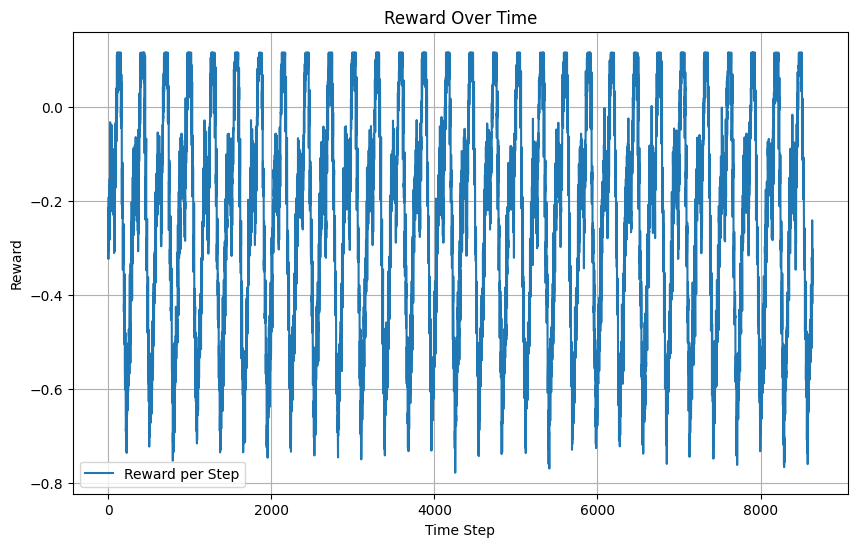

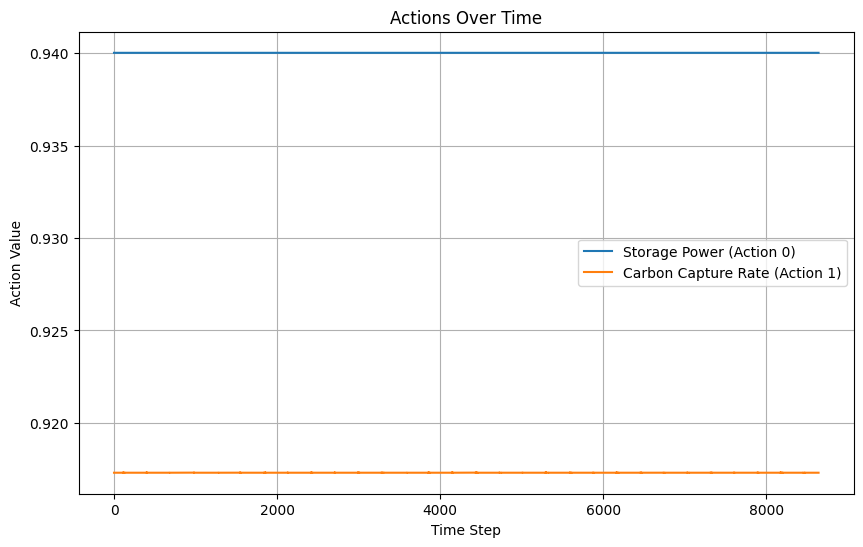

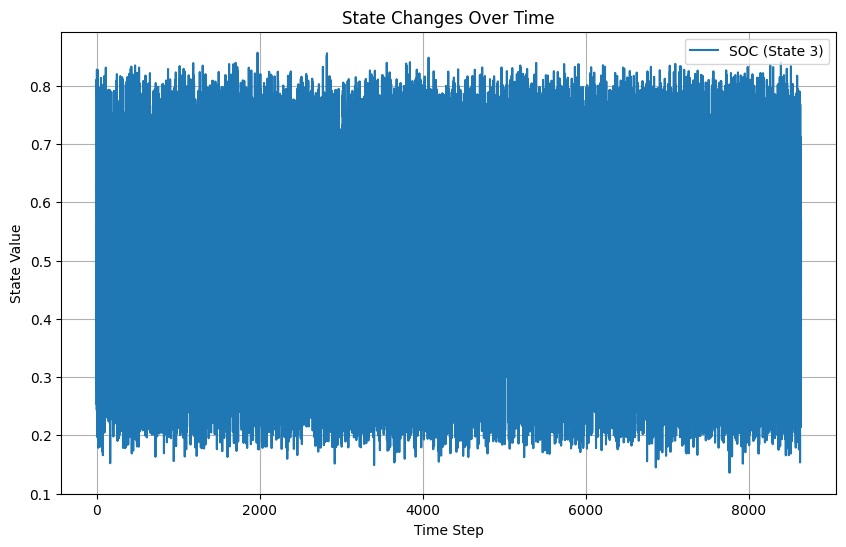

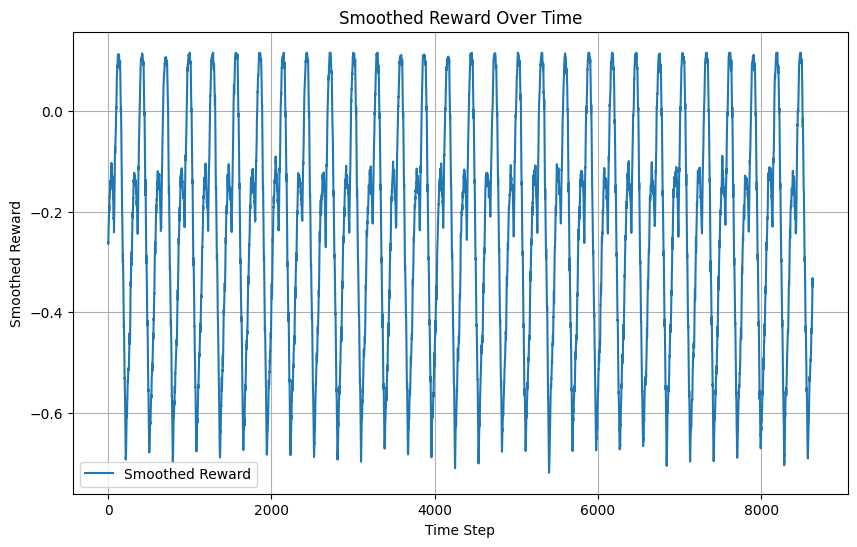

In [5]:
import matplotlib.pyplot as plt
import numpy as np

obs = test_env.reset()

# 初始化存储变量
rewards = []
actions = []
states = []

# 测试模型
for _ in range(len(test_data)):
    action, _states = best_model.predict(obs, deterministic=True)  # 使用最佳模型预测
    obs, reward, done, info = test_env.step(action)
    actions.append(action.reshape(-1))  # 记录动作
    rewards.append(reward)  # 记录奖励
    states.append(obs.reshape(-1))  # 记录状态
    if done:
        break

actions = np.array(actions)
states = np.array(states)
if len(states.shape) == 1:
    states = states.reshape(-1, 1)

rewards = np.array(rewards)

# 可视化奖励趋势
plt.figure(figsize=(10, 6))
plt.plot(rewards, label="Reward per Step")
plt.title("Reward Over Time")
plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

# 动作变化趋势
plt.figure(figsize=(10, 6))
plt.plot(actions[:, 0], label="Storage Power (Action 0)")
if actions.shape[1] > 1:  # 如果有多个动作
    plt.plot(actions[:, 1], label="Carbon Capture Rate (Action 1)")
plt.title("Actions Over Time")
plt.xlabel("Time Step")
plt.ylabel("Action Value")
plt.legend()
plt.grid()
plt.show()

# 关键状态变量变化
plt.figure(figsize=(10, 6))
if states.shape[1] > 3:  # 确保第 4 列 (索引为 3) 存在
    plt.plot(states[:, 3], label="SOC (State 3)")  # 绘制储能设备状态 (SOC)
else:
    print("State dimension too small, cannot plot SOC.")

plt.title("State Changes Over Time")
plt.xlabel("Time Step")
plt.ylabel("State Value")
plt.legend()
plt.grid()
plt.show()


# 平滑奖励趋势
def moving_average(data, window_size):
    data = np.array(data).flatten()
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# 平滑奖励曲线
rewards = np.array(rewards).flatten()
plt.figure(figsize=(10, 6))
plt.plot(moving_average(rewards, window_size=10), label="Smoothed Reward")
plt.title("Smoothed Reward Over Time")
plt.xlabel("Time Step")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.grid()
plt.show()
